In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import pickle as pkl
from schnetpack.nn import build_mlp
from sklearn.metrics import root_mean_squared_error

from typing import Sequence, Union, Callable, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

import schnetpack as spk
import schnetpack.nn as snn
import schnetpack.properties as properties

# from torch.optim.lr_scheduler import StepLR

In [14]:
torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda:1")

### Load Data

### Target: Absorption_max_nm

In [16]:
# train_data = pd.read_pickle('/home/propad/gnn/SchNet/embeddings_SchNet/train_clean_scalar_schnet_train.pkl')
# test_data = pd.read_pickle('/home/propad/gnn/SchNet/embeddings_SchNet/train_clean_scalar_schnet_test.pkl')
# test_eval = pd.read_pickle('/home/propad/gnn/SchNet/embeddings_SchNet/test_clean_scalar_schnet.pkl')

# train_data = pd.read_pickle('../data/train_clean_scalar_painn_train.pkl')
# test_data = pd.read_pickle('../data/train_clean_scalar_painn_test.pkl')
# test_eval = pd.read_pickle('../data/test_clean_scalar_painn.pkl')

In [12]:
train_data = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/train_clean_scalar_dimenet_train.pkl')
train_data_clean = train_data[train_data['Concatenated_embedding'].apply(lambda x: not torch.isnan(x).any())]
train_data = train_data_clean.reset_index(drop=True)

test_data = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/train_clean_scalar_dimenet_test.pkl')
train_data_clean = test_data[test_data['Concatenated_embedding'].apply(lambda x: not torch.isnan(x).any())]
test_data = train_data_clean.reset_index(drop=True)

test_eval = pd.read_pickle('/home/propad/gnn/DimeNet/embeddings_DimeNet/test_clean_scalar_dimenet.pkl')
train_data_clean = test_eval[test_eval['Concatenated_embedding'].apply(lambda x: not torch.isnan(x).any())]
test_eval = train_data_clean.reset_index(drop=True)

train_tensor = torch.stack(train_data['Concatenated_embedding'].to_list(), dim=0)
train_target = torch.FloatTensor(train_data['Absorption_max_nm'].to_list())
mean_train = train_target.mean()
std_train = train_target.std()
train_target_norm = (train_target - train_target.mean()) / train_target.std()
train_dataset = TensorDataset(train_tensor, train_target_norm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_tensor = torch.stack(test_data['Concatenated_embedding'].to_list(), dim=0)
test_target = torch.FloatTensor(test_data['Absorption_max_nm'].to_list())
test_target_norm = (test_target - test_target.mean()) / test_target.std()
test_dataset = TensorDataset(test_tensor, test_target_norm)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

test_eval_tensor = torch.stack(test_eval['Concatenated_embedding'].to_list(), dim=0)
test_eval_target = torch.FloatTensor(test_eval['Absorption_max_nm'].to_list())
test_eval_target_norm = (test_eval_target - test_eval_target.mean()) / test_eval_target.std()
test_eval_dataset = TensorDataset(test_eval_tensor, test_eval_target_norm)
test_eval_loader = DataLoader(test_eval_dataset, batch_size=32, shuffle=True)

In [13]:
for i, batch in enumerate(test_loader):
    inputs, labels = batch
    
    # Check for NaN values in inputs and labels
    if torch.isnan(inputs).any():
        print(f"NaN detected in inputs at batch {i}")
        
    if torch.isnan(labels).any():
        print(f"NaN detected in labels at batch {i}")

In [14]:
class MLPModel(nn.Module):
    def __init__(self, n_in, n_out, n_hidden, n_layers, activation):
        super().__init__()
        self.mlp = spk.nn.build_mlp(
            n_in=n_in,
            n_out=n_out,
            n_hidden=n_hidden,
            n_layers=n_layers,
            activation=activation,
        )

    def forward(self, emb):
        return self.mlp(emb)

In [15]:
model = MLPModel(100, 1, [512, 256, 128], n_layers=4, activation=F.silu)
model.to(device)

MLPModel(
  (mlp): Sequential(
    (0): Dense(in_features=100, out_features=512, bias=True)
    (1): Dense(in_features=512, out_features=256, bias=True)
    (2): Dense(in_features=256, out_features=128, bias=True)
    (3): Dense(
      in_features=128, out_features=1, bias=True
      (activation): Identity()
    )
  )
)

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [17]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs.squeeze(1), labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [18]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0
EPOCHS = 500

train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)
    train_loss_values.append(avg_loss)
    
    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to("cuda:1")
            vlabels = vlabels.to("cuda:1")
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.squeeze(1), vlabels).item()
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_loss_values.append(avg_vloss)
    
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # scheduler.step()
    scheduler.step(avg_vloss)

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 1092778.9467034498
  batch 200 loss: nan
LOSS train nan valid nan
EPOCH 2:
  batch 100 loss: nan
  batch 200 loss: nan
LOSS train nan valid nan
EPOCH 3:
  batch 100 loss: nan
  batch 200 loss: nan
LOSS train nan valid nan
EPOCH 4:
  batch 100 loss: nan
  batch 200 loss: nan
LOSS train nan valid nan
EPOCH 5:
  batch 100 loss: nan
  batch 200 loss: nan
LOSS train nan valid nan
EPOCH 6:
  batch 100 loss: nan
  batch 200 loss: nan
LOSS train nan valid nan
EPOCH 7:


KeyboardInterrupt: 

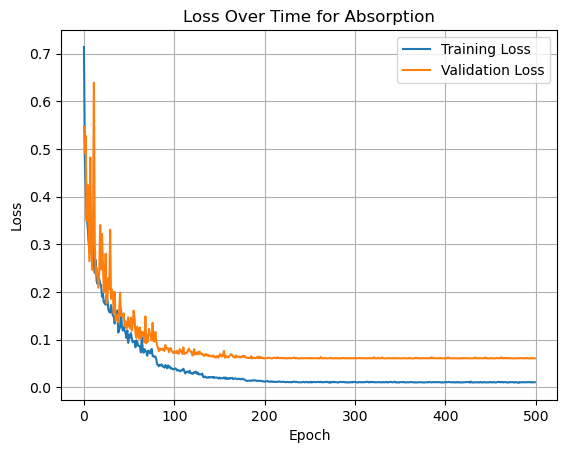

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss values
plt.plot(train_loss_values, label='Training Loss')
plt.plot([val for val in val_loss_values], label='Validation Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title('Loss Over Time for Absorption')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# After training, evaluate the model on test data
model.eval()  # Set the model to evaluation mode
running_test_loss = 0.0

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

with torch.no_grad():  # Disable gradient calculation
    for i, data in enumerate(test_eval_loader):
        inputs, labels = data
        inputs = inputs.to("cuda:1")
        labels = labels.to("cuda:1")
        
        # Forward pass through the model
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(1), labels)
                
        # Append actual and predicted values to lists
        actual_values.extend(labels.cpu().numpy())
        predicted_values.extend(outputs.squeeze(1).cpu().numpy())

        running_test_loss += loss.item()

# Calculate the average loss over the test dataset
avg_test_loss = running_test_loss / (i + 1)

actual_values_unscaled = [i * std_train.item() + mean_train.item() for i in actual_values]
predicted_values_unscaled = [i * std_train.item() + mean_train.item() for i in predicted_values]

# Compute R^2 and RMSE
r2 = np.corrcoef(actual_values_unscaled, predicted_values_unscaled)[0,1] **2
rmse = root_mean_squared_error(actual_values_unscaled, predicted_values_unscaled)

print(f"R^2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Average test loss: {avg_test_loss}")


R^2: 0.941
RMSE: 23.480
Average test loss: 0.059404854848980906
